In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from PIL import ImageDraw
from random import randint
from torchvision.models import resnet34, vgg16_bn, resnet50

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
path = Path('/home/jupyter/data/lfw')

In [7]:
path_img = path

In [8]:
fs = get_image_files(path_img, recurse=True); len(fs)

13233

In [9]:
size = 128
bs = 32
size, bs

(128, 32)

In [10]:
src = (ImageImageList.from_folder(path_img)
                    .use_partial_data(1., seed=42)
                    .split_by_rand_pct(0.1, seed=42))

In [11]:
class TfmPixelXOnly(TfmPixel):
    def __call__(self, *args, **kwargs):
        kwargs.pop('use_on_y', None)
        return super().__call__(*args, use_on_y=False, **kwargs)

In [12]:
def _draw_box(x):
    xy = x.shape[1:]
    bw, bh = randint(int(xy[0]*0.1), int(xy[0]*0.2)), randint(int(xy[1]*0.1), int(xy[1]*0.2))
    bx1, by1 = randint(0, xy[0]-bw), randint(0, xy[1]-bh)
    x[:, bx1:bx1+bh, by1:by1+bw] = 0
    return x

def _rand_boxes(x):
    for _ in range(randint(12, 17)): x = _draw_box(x)
    return x
rand_boxes = TfmPixelXOnly(_rand_boxes)

In [13]:
x_tfm, y_tfm = get_transforms(max_zoom=0.2)
y_tfm = x_tfm
x_tfm.append(rand_boxes())

In [14]:
data = (src
        .label_from_func(lambda x: x)
        .transform((x_tfm, x_tfm), tfm_y=True, size=size)
        .databunch(bs=bs).normalize(imagenet_stats, do_y=True)
       )

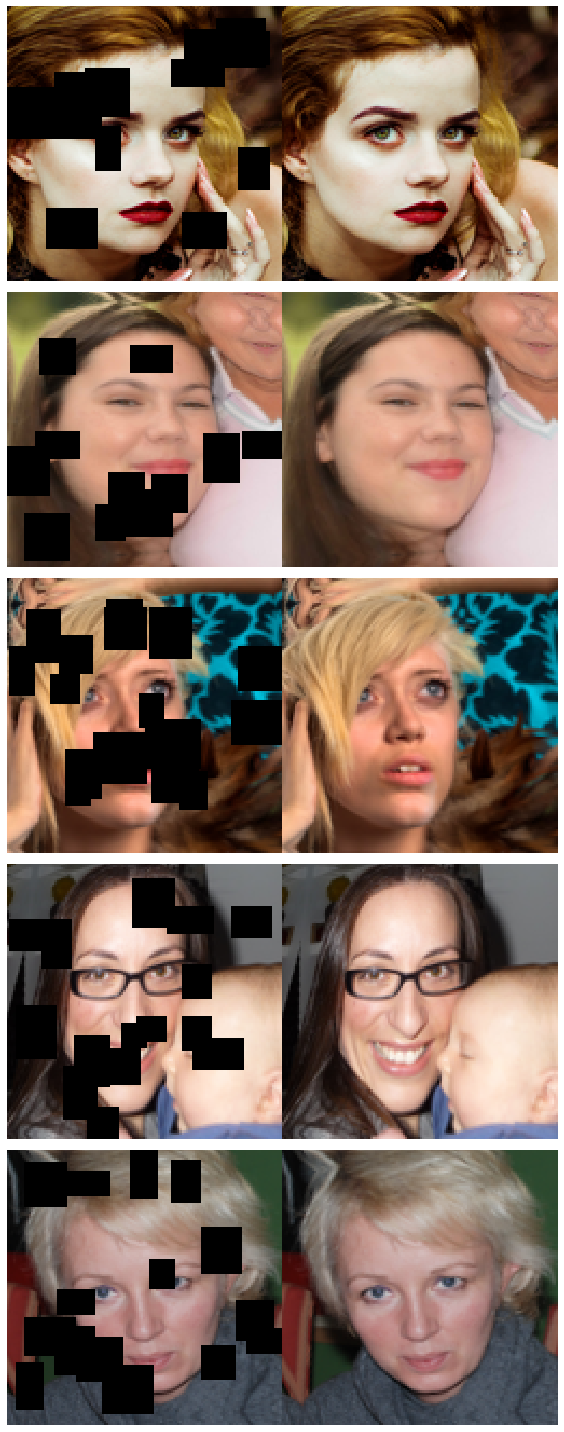

In [15]:
data.show_batch()

## Feature loss

In [16]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [17]:
base_loss = F.l1_loss

In [18]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layers, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = layers
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layers))
              ] + [f'gram_{i}' for i in range(len(layers))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [19]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [20]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
layers = [vgg_m[i] for i in blocks]

In [21]:
feat_loss = FeatureLoss(vgg_m, layers=layers[2:5], layer_wgts=[5, 15, 2])

## Train

In [22]:
learn = None
gc.collect()

22246

In [23]:
learn = unet_learner(data, models.resnet50, wd=1e-3, loss_func=feat_loss,
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Spectral,
                     self_attention=True, y_range=(-3, 3)).to_fp16()

In [22]:
learn.load('res50-128-stage1_1')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


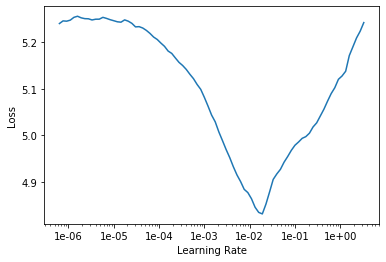

In [22]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr = 1e-3

In [23]:
learn.freeze()
learn.fit_one_cycle(3, lr, pct_start=0.8)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.780503,1.756771,0.122366,0.159947,0.211245,0.068003,0.342474,0.719701,0.133035,57:23
1,1.521417,1.545124,0.122728,0.140947,0.180994,0.059109,0.297571,0.625808,0.117967,57:31
2,1.247125,1.238162,0.076774,0.113456,0.147915,0.049614,0.236465,0.511777,0.102161,57:31


In [24]:
learn.save('res50-128-stage1_1')

In [24]:
learn.load('res50-128-stage2_1')

Learner(data=ImageDataBunch;

Train: LabelList (63000 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/jupyter/data/ffhq/thumbnails128x128;

Valid: LabelList (7000 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/jupyter/data/ffhq/thumbnails128x128;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


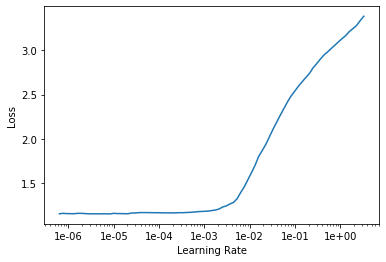

In [25]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 3e-4), pct_start=0.8,
                    callbacks=[SaveModelCallback(learn, every='epoch')])

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.159734,1.142487,0.069213,0.104497,0.135664,0.045821,0.218314,0.473049,0.095928,1:00:13
1,1.171383,1.149698,0.071196,0.105060,0.136540,0.045933,0.218123,0.477564,0.095282,1:09:19
2,1.186423,1.198443,0.087634,0.109040,0.140278,0.046927,0.225157,0.492322,0.097085,1:10:06
3,1.169185,1.182211,0.080320,0.107849,0.139057,0.046477,0.222834,0.489387,0.096288,1:10:07
4,1.102894,1.091022,0.065311,0.099676,0.129568,0.043940,0.207901,0.453206,0.091421,1:10:07


In [27]:
learn.save('res50-128-stage2_2')

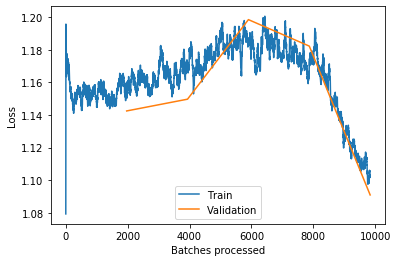

In [28]:
learn.recorder.plot_losses()

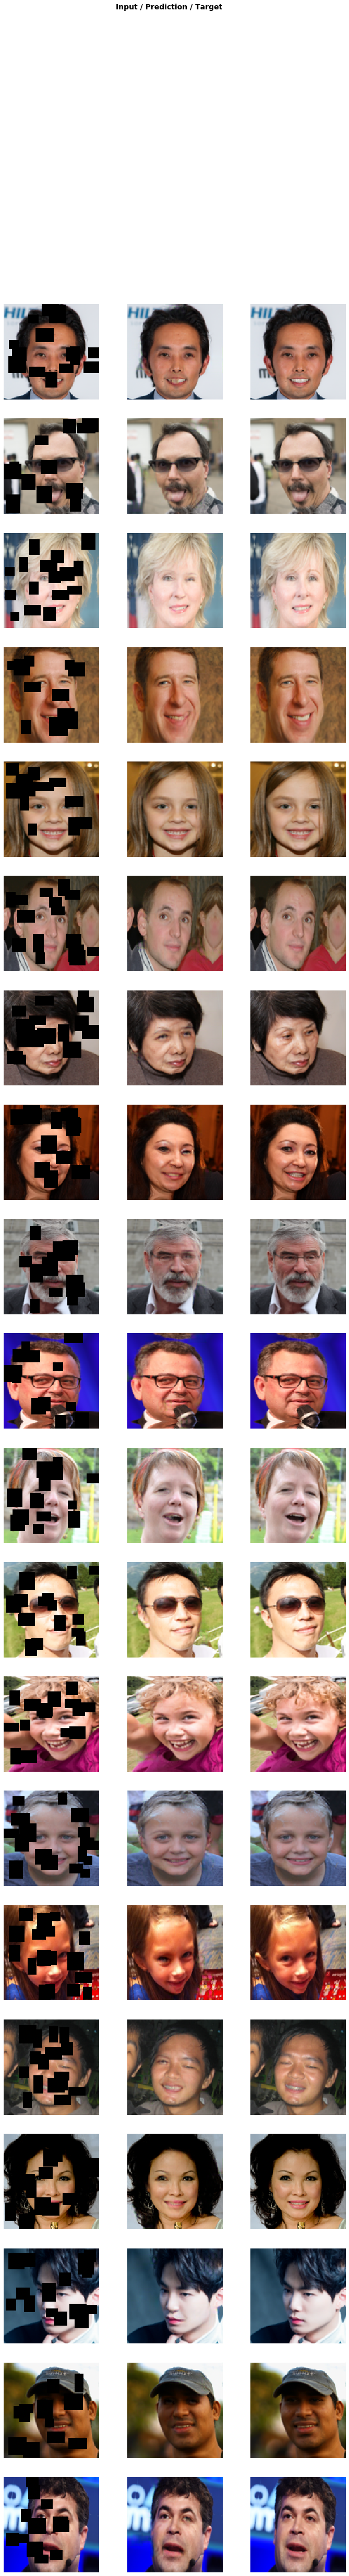

In [29]:
learn.show_results(ds_type=DatasetType.Valid, rows=20)

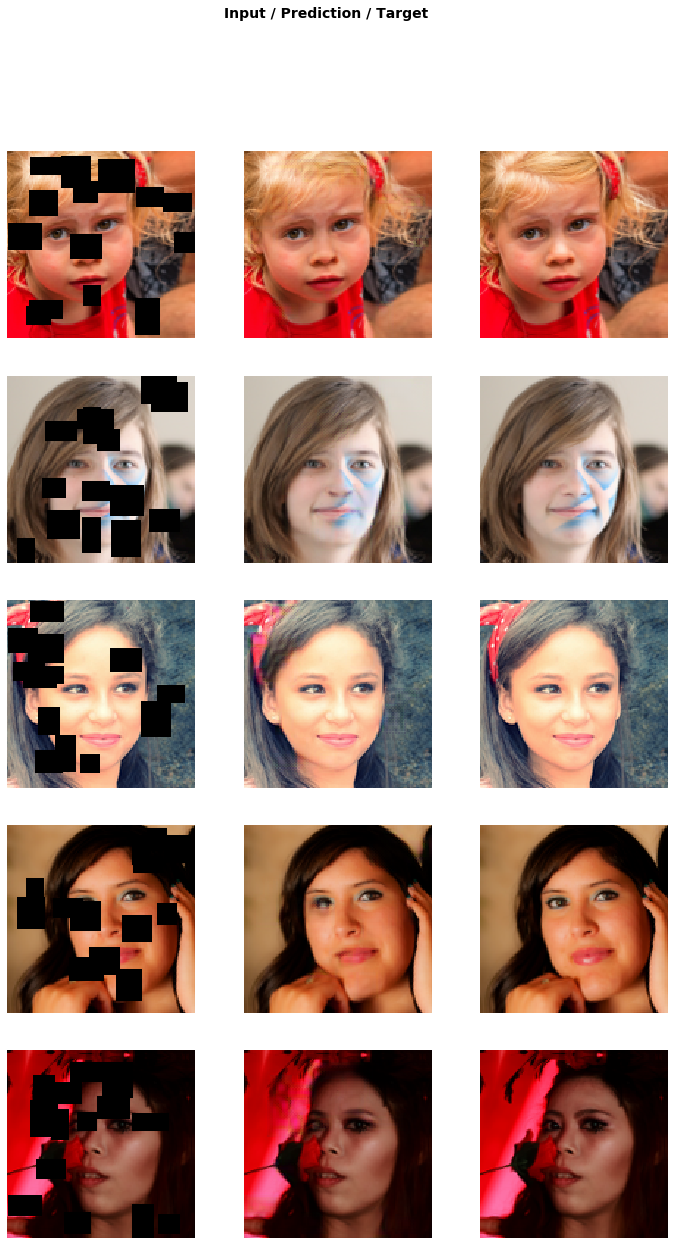

In [30]:
learn.show_results(ds_type=DatasetType.Train)